# Model Training

In [100]:
import os
from keras.preprocessing import image
import matplotlib.pyplot as plt 
import numpy as np
from keras.utils.np_utils import to_categorical
import random,shutil
from keras.models import Sequential
from keras.layers import Dropout,Conv2D,Flatten,Dense, MaxPooling2D, BatchNormalization
from keras.models import load_model

In [101]:
def generator(dir, gen=image.ImageDataGenerator(rescale=1./255), shuffle=True,batch_size=1,target_size=(24,24),class_mode='categorical' ):

    return gen.flow_from_directory(dir,batch_size=batch_size,shuffle=shuffle,color_mode='grayscale',class_mode=class_mode,target_size=target_size)


In [102]:
BS= 32
TS=(24,24)
train_batch= generator('data/train',shuffle=True, batch_size=BS,target_size=TS)
valid_batch= generator('data/valid',shuffle=True, batch_size=BS,target_size=TS)
SPE= len(train_batch.classes)//BS
VS = len(valid_batch.classes)//BS
print(SPE,VS)

Found 499 images belonging to 2 classes.
Found 508 images belonging to 2 classes.
15 15


In [103]:
img,labels= next(train_batch)
print(img.shape)

(32, 24, 24, 1)


In [104]:
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(24,24,1)),
    MaxPooling2D(pool_size=(1,1)),
    Conv2D(32,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(1,1)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(1,1)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='sigmoid')
])

In [105]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [106]:
model.fit_generator(train_batch, validation_data=valid_batch,epochs=25,steps_per_epoch=SPE ,validation_steps=VS)

Epoch 1/25
15/15 [==============================] - 23s 1s/step - loss: 0.7820 - accuracy: 0.4918 - val_loss: 0.6851 - val_accuracy: 0.5750
Epoch 2/25
15/15 [==============================] - 10s 665ms/step - loss: 0.6857 - accuracy: 0.5238 - val_loss: 0.6762 - val_accuracy: 0.6771
Epoch 3/25
15/15 [==============================] - 10s 650ms/step - loss: 0.6671 - accuracy: 0.6240 - val_loss: 0.6401 - val_accuracy: 0.7208
Epoch 4/25
15/15 [==============================] - 10s 686ms/step - loss: 0.6371 - accuracy: 0.6402 - val_loss: 0.5474 - val_accuracy: 0.7500
Epoch 5/25
15/15 [==============================] - 10s 695ms/step - loss: 0.5757 - accuracy: 0.6846 - val_loss: 0.5540 - val_accuracy: 0.7583
Epoch 6/25
15/15 [==============================] - 10s 678ms/step - loss: 0.5478 - accuracy: 0.7390 - val_loss: 0.5080 - val_accuracy: 0.7521
Epoch 7/25
15/15 [==============================] - 11s 760ms/step - loss: 0.5110 - accuracy: 0.7623 - val_loss: 0.4545 - val_accuracy: 0.8042
Ep

In [107]:
model.save('models/new_cnn_Cat2.h5', overwrite=True)

# Project Implementation

In [108]:
import cv2
import os
# from keras.models import load_model
import numpy as np
from pygame import mixer
import time

In [109]:
mixer.init()
sound = mixer.Sound('alarm.wav')

face = cv2.CascadeClassifier('haar cascade files\haarcascade_frontalface_alt.xml')
leye = cv2.CascadeClassifier('haar cascade files\haarcascade_lefteye_2splits.xml')
reye = cv2.CascadeClassifier('haar cascade files\haarcascade_righteye_2splits.xml')


In [110]:
lbl=['Close','Open']

In [111]:
lbl=['Close','Open']

model = load_model('models/cnncat2.h5')
path = os.getcwd()
cap = cv2.VideoCapture(0)
font = cv2.FONT_HERSHEY_COMPLEX_SMALL
count=0
score=0
thicc=2
rpred=[99]
lpred=[99]

In [112]:
while(True):
    ret, frame = cap.read()
    height,width = frame.shape[:2] 

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    faces = face.detectMultiScale(gray,minNeighbors=5,scaleFactor=1.1,minSize=(25,25))
    left_eye = leye.detectMultiScale(gray)
    right_eye =  reye.detectMultiScale(gray)

    cv2.rectangle(frame, (0,height-50) , (200,height) , (0,0,0) , thickness=cv2.FILLED )

    for (x,y,w,h) in faces:
        cv2.rectangle(frame, (x,y) , (x+w,y+h) , (100,100,100) , 1 )

    for (x,y,w,h) in right_eye:
        r_eye=frame[y:y+h,x:x+w]
        count=count+1
        r_eye = cv2.cvtColor(r_eye,cv2.COLOR_BGR2GRAY)
        r_eye = cv2.resize(r_eye,(24,24))
        r_eye= r_eye/255
        r_eye=  r_eye.reshape(24,24,-1)
        r_eye = np.expand_dims(r_eye,axis=0)
        rpred = model.predict_classes(r_eye)
        if(rpred[0]==1):
            lbl='Open' 
        if(rpred[0]==0):
            lbl='Closed'
        break

    for (x,y,w,h) in left_eye:
        l_eye=frame[y:y+h,x:x+w]
        count=count+1
        l_eye = cv2.cvtColor(l_eye,cv2.COLOR_BGR2GRAY)  
        l_eye = cv2.resize(l_eye,(24,24))
        l_eye= l_eye/255
        l_eye=l_eye.reshape(24,24,-1)
        l_eye = np.expand_dims(l_eye,axis=0)
        lpred = model.predict_classes(l_eye)
        if(lpred[0]==1):
            lbl='Open'   
        if(lpred[0]==0):
            lbl='Closed'
        break

    if(rpred[0]==0 and lpred[0]==0):
        score=score+1
        cv2.putText(frame,"Closed",(10,height-20), font, 1,(255,255,255),1,cv2.LINE_AA)
    # if(rpred[0]==1 or lpred[0]==1):
    else:
        score=score-1
        cv2.putText(frame,"Open",(10,height-20), font, 1,(255,255,255),1,cv2.LINE_AA)
    
        
    if(score<0):
        score=0   
    cv2.putText(frame,'Score:'+str(score),(100,height-20), font, 1,(255,255,255),1,cv2.LINE_AA)
    if(score>15):
        #person is feeling sleepy so we beep the alarm
        cv2.imwrite(os.path.join(path,'image.jpg'),frame)
        try:
            sound.play()
            
        except:  # isplaying = False
            pass
        if(thicc<16):
            thicc= thicc+2
        else:
            thicc=thicc-2
            if(thicc<2):
                thicc=2
        cv2.rectangle(frame,(0,0),(width,height),(0,0,255),thicc) 
    cv2.imshow('frame',frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

 # LIME Explaination

In [185]:
# %tensorflow_version 1.x
import numpy as np
import keras
from keras.applications.imagenet_utils import decode_predictions
import skimage.io 
import skimage.segmentation
import copy
import sklearn
import sklearn.metrics
from sklearn.linear_model import LinearRegression
import warnings

print('Notebook running: keras ', keras.__version__)
np.random.seed(222)

Notebook running: keras  2.4.3


In [254]:
warnings.filterwarnings('ignore') 
inceptionV3_model = keras.applications.inception_v3.InceptionV3() #Load pretrained model

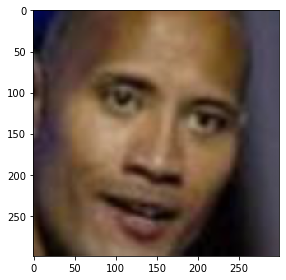

In [255]:
Xi = skimage.io.imread("Dwayne_Johnson_0001.jpg")
Xi = skimage.transform.resize(Xi, (299,299)) 
Xi = (Xi - 0.5)*2 #Inception pre-processing
skimage.io.imshow(Xi/2+0.5) # Show image before inception preprocessing

In [256]:
np.random.seed(222)
preds = inceptionV3_model.predict(Xi[np.newaxis,:,:,:])
decode_predictions(preds)[0] #Top 5 classes

[('n03814639', 'neck_brace', 0.47652256),
 ('n02669723', 'academic_gown', 0.095038526),
 ('n04350905', 'suit', 0.059469596),
 ('n03884397', 'panpipe', 0.056413896),
 ('n04591157', 'Windsor_tie', 0.050331194)]

In [257]:
top_pred_classes = preds[0].argsort()[-8:][::-1]
top_pred_classes                #Index of top 5 classes

array([678, 400, 834, 699, 906, 683, 432, 610], dtype=int64)

In [258]:
superpixels = skimage.segmentation.quickshift(Xi, kernel_size=4,max_dist=200, ratio=0.2)
num_superpixels = np.unique(superpixels).shape[0]
num_superpixels

56

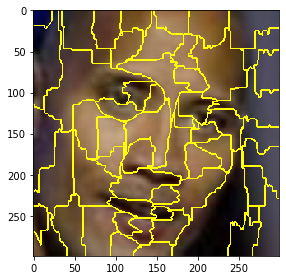

In [259]:
skimage.io.imshow(skimage.segmentation.mark_boundaries(Xi/2+0.5, superpixels))

In [260]:
num_perturb = 150
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
perturbations[0] #Show example of perturbation

array([1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1])

In [261]:
def perturb_image(img,perturbation,segments):
  active_pixels = np.where(perturbation == 1)[0]
  mask = np.zeros(segments.shape)
  for active in active_pixels:
      mask[segments == active] = 1 
  perturbed_image = copy.deepcopy(img)
  perturbed_image = perturbed_image*mask[:,:,np.newaxis]
  return perturbed_image

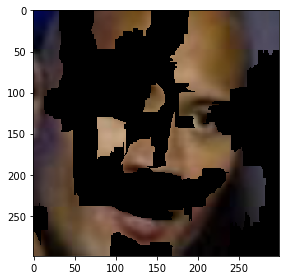

In [262]:
skimage.io.imshow(perturb_image(Xi/2+0.5,perturbations[0],superpixels))

In [ ]:
predictions = []
for pert in perturbations:
  perturbed_img = perturb_image(Xi,pert,superpixels)
  pred = inceptionV3_model.predict(perturbed_img[np.newaxis,:,:,:])
  predictions.append(pred)

predictions = np.array(predictions)
predictions.shape

In [ ]:
original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
distances.shape

In [ ]:
kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
weights.shape

In [ ]:
class_to_explain = top_pred_classes[0]
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
coeff = simpler_model.coef_[0]
coeff

In [ ]:
num_top_features = 4
top_features = np.argsort(coeff)[-num_top_features:] 
top_features

In [ ]:
mask = np.zeros(num_superpixels) 
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(Xi/2+0.5,mask,superpixels) )